In [7]:
# Set the working directory, change to your specific directory
import os
os.chdir('/Your_project_folder')

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from CNN_models.vgg import vgg13_bn
from CNN_models.densenet import densenet169
from CNN_models.resnet import resnet50
import matplotlib.pyplot as plt
import numpy as np
import os

In [8]:
# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- list of altered datasets -------
altered_datasets = ['cifar10_FGSA_MLP.pth', 'cifar10_FGSA_VGG13.pth', 'cifar10_FGSA_resnet50.pth', 'cifar10_FGSA_densenet169.pth']

# select the altered dataset you want to evaluate your model on
altered_dataset = altered_datasets[-2]
folder_path = './cifar10_datasets/'
dataset_path = os.path.join(folder_path, altered_dataset)

# ---------- Load the CIFAR-10 test dataset -------------

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

#--------- Load the altered dataset ----------

class CustomDataset(Dataset):
    def __init__(self, dataset_dict, transform = None):
        self.dataset_dict = dataset_dict
        self.transform = transform

    def __len__(self):
        return len(self.dataset_dict)

    def __getitem__(self, index):
        data = self.dataset_dict[index]
        image = data['image']
        if self.transform:
            image = self.transform(data['image'])
        label = data['label']

        return image, label

# Load the dataset dictionary
loaded_dataset = torch.load(dataset_path)

# Create an instance of the CustomDataset
altered_dataset = CustomDataset(loaded_dataset, transform = transform)
altered_loader = DataLoader(altered_dataset, batch_size=1024, shuffle=False)

# ------------- Load the pretrained model ------------
pretrained_model = resnet50(pretrained=True) # choose from the different models: vgg13_bn, densenet169, resnet50
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()


# -----------calculate accuracies -----------

def accuracy_calc(loader, classes, dataset):
    num_classes = len(classes)
    # Initialize a dictionary to store per-class counts
    class_counts = {class_idx: {'correct': 0, 'total': 0} for class_idx in range(num_classes)}

    with torch.no_grad():
        for inputs, labels in loader:

            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = pretrained_model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Update counts for each class
            for class_idx in range(num_classes):
                class_mask = labels == class_idx
                class_total = class_mask.sum().item()
                class_correct = (predicted[class_mask] == class_idx).sum().item()

                class_counts[class_idx]['correct'] += class_correct
                class_counts[class_idx]['total'] += class_total

    # Calculate per-class accuracy
    per_class_accuracy = {class_idx: class_counts[class_idx]['correct'] / class_counts[class_idx]['total']
                        for class_idx in range(num_classes)}

    # Print per-class accuracy
    total_accuracy = 0
    for class_idx in range(num_classes):
        print(f'{dataset} accuracy for {classes[class_idx]}: {100 * per_class_accuracy[class_idx]:.2f}%') 
        total_accuracy += per_class_accuracy[class_idx]

    print(f'{dataset} total accuracy: {100 * total_accuracy/10:.2f}%')

classes  = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
accuracy_calc(test_loader, classes, 'CIFAR10')
accuracy_calc(altered_loader, classes, 'Adversarial CIFAR10')


Files already downloaded and verified
CIFAR10 accuracy for Airplane: 94.50%
CIFAR10 accuracy for Car: 97.00%
CIFAR10 accuracy for Bird: 91.70%
CIFAR10 accuracy for Cat: 85.30%
CIFAR10 accuracy for Deer: 94.60%
CIFAR10 accuracy for Dog: 91.10%
CIFAR10 accuracy for Frog: 95.00%
CIFAR10 accuracy for Horse: 95.50%
CIFAR10 accuracy for Ship: 96.10%
CIFAR10 accuracy for Truck: 95.70%
CIFAR10 total accuracy: 93.65%
Adversarial CIFAR10 accuracy for Airplane: 56.40%
Adversarial CIFAR10 accuracy for Car: 88.10%
Adversarial CIFAR10 accuracy for Bird: 83.00%
Adversarial CIFAR10 accuracy for Cat: 44.70%
Adversarial CIFAR10 accuracy for Deer: 67.20%
Adversarial CIFAR10 accuracy for Dog: 47.00%
Adversarial CIFAR10 accuracy for Frog: 73.90%
Adversarial CIFAR10 accuracy for Horse: 59.80%
Adversarial CIFAR10 accuracy for Ship: 66.10%
Adversarial CIFAR10 accuracy for Truck: 68.00%
Adversarial CIFAR10 total accuracy: 65.42%


Visualize the altered datasets

Files already downloaded and verified


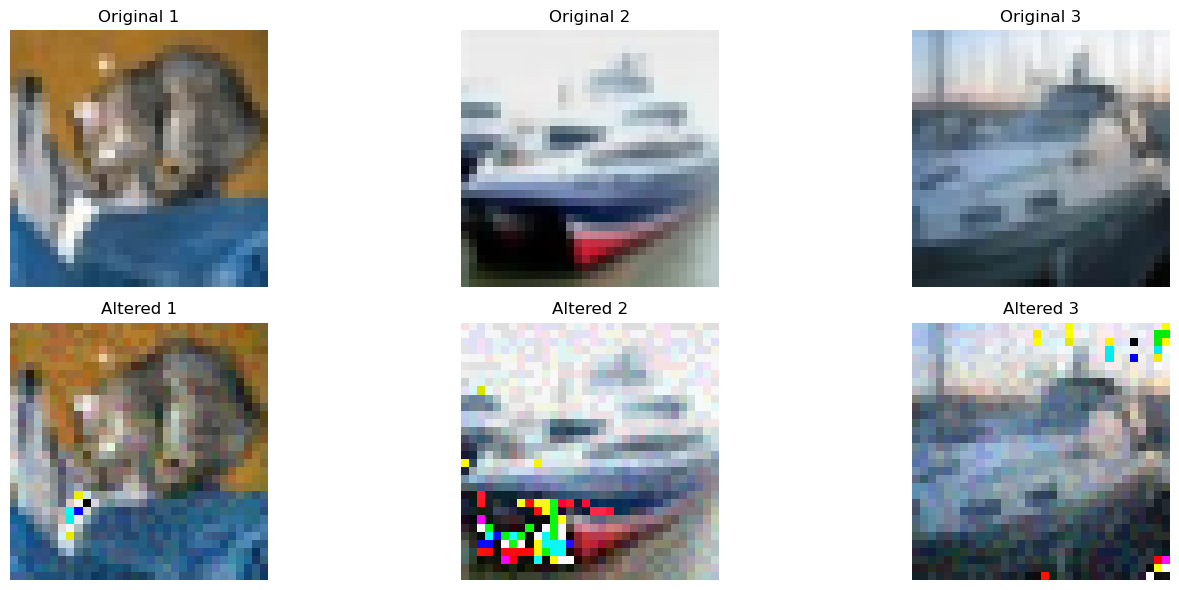

In [10]:
# -------- list of altered datasets -------
altered_datasets = ['cifar10_FGSA_MLP.pth', 'cifar10_FGSA_VGG13.pth', 'cifar10_FGSA_resnet50.pth', 'cifar10_FGSA_densenet169.pth']


# Original dataset
original_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

# select the altered dataset you want to visualize
altered_dataset = altered_datasets[-2]
folder_path = './cifar10_datasets/'
dataset_path = os.path.join(folder_path, altered_dataset)

loaded_dataset = torch.load(dataset_path)
altered_dataset = CustomDataset(loaded_dataset, transform = None)


# Create a subplot for each image
fig, axes = plt.subplots(2, 3, figsize=(15, 6))

for i in range(3):
    # Original image
    original_image, _ = original_dataset[i]
    axes[0, i].imshow(np.array(original_image))
    axes[0, i].set_title(f'Original {i + 1}')

    # Altered image
    altered_image, _ = altered_dataset[i]
    axes[1, i].imshow(np.array(altered_image))
    axes[1, i].set_title(f'Altered {i + 1}')

# Hide the axes
for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()
